# Credit Risk Modelling

**Description:**
In this competition, you must explore and cleanse a dataset consisting of over 111,000 loan records to determine the best way to predict whether a loan applicant will fully repay or default on a loan. You must then build a machine learning model that returns the unique loan ID and a loan status label that indicates whether the loan will be fully paid or charged off.

### Getting all the Dependencies

In [5]:
# Installing dependencies
!pip install --upgrade pip
!pip install numpy --upgrade --user
!pip install pandas --upgrade --user
!pip install scikit-learn --upgrade --user

     |████████████████████████████████| 1.4MB 838kB/s eta 0:00:01
  Found existing installation: pip 19.2.2
    Uninstalling pip-19.2.2:
      Successfully uninstalled pip-19.2.2
     |████████████████████████████████| 20.0MB 7.1kB/s eta 0:00:01     |█████████████████               | 10.7MB 4.4MB/s eta 0:00:03
ERROR: azureml-train-automl 1.0.57 has requirement numpy<=1.16.2,>=1.11.0, but you'll have numpy 1.17.3 which is incompatible.
ERROR: azureml-train-automl 1.0.57 has requirement onnxmltools==1.4.1, but you'll have onnxmltools 1.5.0 which is incompatible.
ERROR: azureml-opendatasets 1.0.57 has requirement numpy<=1.16.2,>=1.11.0, but you'll have numpy 1.17.3 which is incompatible.
ERROR: azureml-automl-core 1.0.57 has requirement numpy<=1.16.2,>=1.11.0, but you'll have numpy 1.17.3 which is incompatible.
ERROR: azureml-automl-core 1.0.57 has requirement onnxmltools==1.4.1, but you'll have onnxmltools 1.5.0 which is incompatible.
     |████████████████████████████████| 10.4MB 124kB/

In [11]:
# Avoiding Warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
# Importing Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

### Loading the Data

In [2]:
# Importing Dataset
train = pd.read_csv("https://dim-mlpython.s3.amazonaws.com/CreditRiskModeling/train.csv", low_memory=False)
test = pd.read_csv("https://dim-mlpython.s3.amazonaws.com/CreditRiskModeling/test.csv", low_memory=False)

### Describing the data

In [3]:
# For each column heading we replace " " and convert the heading in lowercase 
cleancolumn = []
for i in range(len(train.columns)):
    cleancolumn.append(train.columns[i].replace(' ', '_').lower())
train.columns = cleancolumn

In [ ]:
train.head()

In [ ]:
print(train.shape)
train.describe()

In [ ]:
train.info()

### Removing the duplicates

Loan ID is unique for every loan process so we will use Loan ID to remove duplicates

In [4]:
# Check the unique values, to see if there is any duplicates
unique_loanid=train['loan_id'].unique().tolist()
print("Total samples in data:", str(train.shape[0]))
print("Total unique samples in data:", str(len(unique_loanid)))
print("Duplicate samples in data:", str(train.shape[0] - len(unique_loanid)))

Total samples in data: 77823
Total unique samples in data: 62237
Duplicate samples in data: 15586


In [5]:
# Drop the duplicates
train = train.drop_duplicates()
print("Total samples in data:", str(train.shape[0]))
print("Total unique samples in data:", str(len(unique_loanid)))
print("Duplicate samples in data:", str(train.shape[0] - len(unique_loanid)))

Total samples in data: 69076
Total unique samples in data: 62237
Duplicate samples in data: 6839


In [6]:
#Get the duplicates
dup_loanid=train[train.duplicated(['loan_id'],keep=False)]
print(dup_loanid.shape)
dup_loanid.describe()

(13678, 19)


,current_loan_amount,credit_score,annual_income,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens
count,13678.000,10003.000,10003.000,13678.000,7238.000,13678.000,13678.000,13678.000,13658.000,13676.000
mean,22734326.610,699.678,72329.080,17.805,34.127,11.254,0.207,15804.026,0.140,0.039
std,41899176.187,24.989,46577.155,7.000,21.766,5.186,0.533,18911.803,0.371,0.299
min,978.000,587.000,9756.000,3.700,0.000,1.000,0.000,0.000,0.000,0.000
25%,9793.000,690.000,44928.000,13.000,15.000,8.000,0.000,5755.250,0.000,0.000
50%,17797.500,708.000,61362.000,16.700,31.000,10.000,0.000,10962.000,0.000,0.000
75%,35046.500,718.000,87014.500,21.400,50.000,14.000,0.000,19879.750,0.000,0.000
max,99999999.000,725.000,934705.000,59.500,91.000,47.000,9.000,291341.000,4.000,9.000


In [7]:
#Sort the duplicate dataframe in ascending order with NA's in last
sorted_df=dup_loanid.sort_values(['current_loan_amount', 'credit_score'], ascending=True, na_position='last')
sorted_df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
58916,07f5fb21-82d8-4cd8-98eb-cef89b460348,90dcf223-324c-4579-9062-9e275d1a9ec0,Fully Paid,978,Short Term,718.000,NaN,Home Mortgage,74313.000,major_purchase,1226.16,34.800,10.000,10,0,16547,17603,0.000,0.000
5957,2bc65e92-50b3-453f-88f4-101aa3f7c631,85e53503-06fe-45f1-8c6e-48618b924167,Fully Paid,979,Short Term,711.000,10+ years,Rent,29367.000,Debt Consolidation,702.36,46.700,nan,11,0,14133,15181,0.000,0.000
62240,2bc65e92-50b3-453f-88f4-101aa3f7c631,85e53503-06fe-45f1-8c6e-48618b924167,Fully Paid,979,Short Term,nan,10+ years,Rent,nan,Debt Consolidation,702.36,46.700,nan,11,0,14133,15181,0.000,0.000
33249,38af5e3a-9d54-456a-b335-21e172018517,5c92cda7-7386-47b4-b3d6-56c0e278e56f,Fully Paid,982,Short Term,697.000,5 years,Home Mortgage,29472.000,Debt Consolidation,44.21,11.500,nan,3,0,2021,8456,0.000,0.000
56983,ae401455-a534-4d31-bafa-3b1e0474a35b,c8c64614-1c34-49d9-a608-64dc942cf447,Fully Paid,983,Short Term,698.000,< 1 year,Rent,37343.000,Debt Consolidation,886.89,13.000,nan,11,0,17472,19074,0.000,0.000


In [8]:
#Considering samples which are genuine
correct_df = sorted_df.drop_duplicates(['loan_id'], keep='first')
print(correct_df.shape)
correct_df.head()

(6839, 19)


,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
58916,07f5fb21-82d8-4cd8-98eb-cef89b460348,90dcf223-324c-4579-9062-9e275d1a9ec0,Fully Paid,978,Short Term,718.000,NaN,Home Mortgage,74313.000,major_purchase,1226.16,34.800,10.000,10,0,16547,17603,0.000,0.000
5957,2bc65e92-50b3-453f-88f4-101aa3f7c631,85e53503-06fe-45f1-8c6e-48618b924167,Fully Paid,979,Short Term,711.000,10+ years,Rent,29367.000,Debt Consolidation,702.36,46.700,nan,11,0,14133,15181,0.000,0.000
33249,38af5e3a-9d54-456a-b335-21e172018517,5c92cda7-7386-47b4-b3d6-56c0e278e56f,Fully Paid,982,Short Term,697.000,5 years,Home Mortgage,29472.000,Debt Consolidation,44.21,11.500,nan,3,0,2021,8456,0.000,0.000
56983,ae401455-a534-4d31-bafa-3b1e0474a35b,c8c64614-1c34-49d9-a608-64dc942cf447,Fully Paid,983,Short Term,698.000,< 1 year,Rent,37343.000,Debt Consolidation,886.89,13.000,nan,11,0,17472,19074,0.000,0.000
47807,df1680ed-de74-4ec4-ab3c-cdacfd2a911e,b44395a3-4f94-41ff-ad65-8f1d8b06919d,Fully Paid,983,Short Term,714.000,5 years,Home Mortgage,44959.000,other,338.32,11.400,nan,9,0,8182,9245,0.000,0.000


In [9]:
#Check if there is any such placeholder in duplicates
correct_df[correct_df['current_loan_amount']==99999999]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens


In [10]:
#check if there is still Na's in duplicates
correct_df[correct_df['credit_score'].isnull()]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens


In [11]:
# Droping the duplicate loan ID's 
train.drop_duplicates(['loan_id'], keep=False, inplace=True)

In [12]:
train.shape

(55398, 19)

In [13]:
# Getting the final train data which is all genuine
train = train.append(correct_df, ignore_index=True)
print(train.shape)
train.describe()

(62237, 19)


,current_loan_amount,credit_score,annual_income,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens
count,62237.000,50997.000,50997.000,62237.000,28203.000,62237.000,62237.000,62237.000,62112.000,62233.000
mean,9429888.029,1157.211,72470.303,18.316,35.066,11.105,0.162,15480.221,0.114,0.028
std,29202977.662,1614.569,60939.354,7.063,21.933,4.986,0.472,20276.316,0.345,0.249
min,885.000,585.000,4268.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000
25%,8060.000,711.000,44681.000,13.500,16.000,8.000,0.000,5925.000,0.000,0.000
50%,13425.000,731.000,61708.000,17.000,32.000,10.000,0.000,11014.000,0.000,0.000
75%,21628.000,743.000,86912.000,21.800,51.000,14.000,0.000,19365.000,0.000,0.000
max,99999999.000,7510.000,8713547.000,62.500,176.000,76.000,12.000,1730472.000,7.000,11.000


### Preprocessing / Cleaning the data

#### Feature: Years in Current Job

Remove the special charachters and other words and make it numeric.

In [14]:
train['years_in_current_job'].unique()

array(['10+ years', '2 years', '7 years', '5 years', '< 1 year',
       '4 years', '8 years', '1 year', '3 years', nan, '6 years',
       '9 years'], dtype=object)

In [15]:
train['years_in_current_job'] = [0 if str(x)=='< 1 year' else x if str(x)=='nan' else int(re.findall(r'\d+', str(x))[0]) for x in train['years_in_current_job']]
train['years_in_current_job'].unique()

array([10.,  2.,  7.,  5.,  0.,  4.,  8.,  1.,  3., nan,  6.,  9.])

#### Feature: Credit Score

Credit Score range is from 0 to 800 but there are some values greater than this basically this is some data error.

In [16]:
train['credit_score'].head(10)

0   6920.000
1    721.000
2    726.000
3    707.000
4    700.000
5    733.000
6    694.000
7    724.000
8   6950.000
9        nan
Name: credit_score, dtype: float64

In [17]:
# Function to bring credit score in range
def credit_range(x):
    if x > 800:
        return int(x/10)
    elif str(x) == 'nan' : 
        return x
    else:
        return int(x)

In [18]:
train['credit_score'] = train['credit_score'].map(credit_range)
train['credit_score'].head(10)

0   692.000
1   721.000
2   726.000
3   707.000
4   700.000
5   733.000
6   694.000
7   724.000
8   695.000
9       nan
Name: credit_score, dtype: float64

#### Feature: Maximum Open Credit

There is one data error which needs to be handled.

In [19]:
print(train.shape)
train[train['maximum_open_credit']=='#VALUE!']

(62237, 19)


,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
35792,b798f46b-e27b-4823-af83-294b1ffc3490,f61890c5-e264-4b0f-a047-9cfa03b9d182,Charged Off,1470,Short Term,nan,2.000,Rent,nan,Debt Consolidation,506.34,15.300,26.000,3,0,0,#VALUE!,0.000,0.000


In [20]:
train = train[train['maximum_open_credit'] != '#VALUE!']
train['maximum_open_credit']= pd.to_numeric(train['maximum_open_credit'])
train.shape

(62236, 19)

#### Feature: Monthly Debt

Monthly debt has Currency symbol due to which its datatype is string, remove it and convert it to numeric.

In [21]:
train['monthly_debt']=train['monthly_debt'].str.strip('$')
train['monthly_debt']=pd.to_numeric(train['monthly_debt'])
train['monthly_debt'].describe()

count   62236.000
mean      963.653
std       642.180
min         0.000
25%       532.188
50%       842.560
75%      1250.362
max     22939.120
Name: monthly_debt, dtype: float64

### Handling Missing Values and Outliers

Describe the data and check which feature has Missing Values and if there is any Outlier. 

In [22]:
train.describe()

,current_loan_amount,credit_score,years_in_current_job,annual_income,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
count,62236.000,50997.000,59559.000,50997.000,62236.000,62236.000,28202.000,62236.000,62236.000,62236.000,62236.000,62111.000,62232.000
mean,9430039.524,720.100,5.880,72470.303,963.653,18.316,35.066,11.105,0.162,15480.470,35785.109,0.114,0.028
std,29203187.823,27.891,3.627,60939.354,642.180,7.063,21.934,4.986,0.472,20276.384,372633.539,0.345,0.249
min,885.000,585.000,0.000,4268.000,0.000,3.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,8060.000,708.000,3.000,44681.000,532.188,13.500,16.000,8.000,0.000,5925.750,12796.000,0.000,0.000
50%,13425.500,728.000,6.000,61708.000,842.560,17.000,32.000,10.000,0.000,11014.000,21813.500,0.000,0.000
75%,21628.000,741.000,10.000,86912.000,1250.362,21.800,51.000,14.000,0.000,19365.250,36476.000,0.000,0.000
max,99999999.000,751.000,10.000,8713547.000,22939.120,62.500,176.000,76.000,12.000,1730472.000,69988086.000,7.000,11.000


#### Outlier treatment: Current Loan Amount

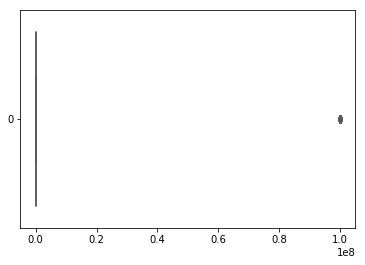

In [23]:
ax = sns.boxplot(data=train['current_loan_amount'], orient="h", palette="Set2")

In [24]:
# check the description their is a placeholder in max value
train[train['current_loan_amount']==99999999.000]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
21,b4130876-c81b-423d-a69b-a7ab6aa76c68,6255b3d6-d167-48eb-8656-78747b31ae1e,Fully Paid,99999999,Short Term,746.000,10.000,Home Mortgage,178293.000,Debt Consolidation,1142.560,19.400,23.000,13,0,38966,347907,0.000,0.000
34,d140c39f-2a26-429e-a68e-874a58df778a,2868249d-856e-4206-a8f7-8adb2dae4db4,Fully Paid,99999999,Short Term,743.000,6.000,Rent,109175.000,Debt Consolidation,1401.080,21.500,nan,12,0,17466,37321,0.000,0.000
37,9b235251-b029-4fb8-b87e-75255f8660d7,81d48734-77cb-4379-9802-fcf77ad82088,Fully Paid,99999999,Short Term,735.000,10.000,Home Mortgage,84456.000,Debt Consolidation,1703.200,24.500,nan,18,0,21182,89373,0.000,0.000
44,45a1ec5e-20cc-40ed-aaf1-a5de6fbd19b1,6d4ad284-7311-4e34-86bb-cfa2a20de736,Fully Paid,99999999,Short Term,735.000,10.000,Home Mortgage,55363.000,Debt Consolidation,516.720,33.400,12.000,19,0,5827,41328,0.000,0.000
50,d1d847ee-43fc-49ac-b9a4-48ab3cc23f9a,97d23b9d-ddbe-4505-adfe-5898ecf1ba88,Fully Paid,99999999,Short Term,746.000,2.000,Home Mortgage,132626.000,Debt Consolidation,1801.500,14.000,nan,14,0,15754,21941,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55362,9c28c63d-75b0-42df-8416-e88cc93ae0a7,3c273143-63ba-400d-810a-c4b80668db72,Fully Paid,99999999,Short Term,737.000,5.000,Home Mortgage,32210.000,Debt Consolidation,456.300,11.100,nan,5,0,4208,4530,0.000,0.000
55374,44bc349f-f21e-46c7-a6c3-1e20bd249e0c,c513cd75-e007-4cf2-b929-07df95b3f825,Fully Paid,99999999,Short Term,734.000,4.000,Home Mortgage,85803.000,Debt Consolidation,986.730,21.900,1.000,6,2,6426,10985,0.000,2.000
55381,13be0ed7-b712-4fb2-9d71-d50e77f3c44f,a88250e8-59b8-47ce-8e6b-e21446d31f5d,Fully Paid,99999999,Short Term,746.000,4.000,Rent,73185.000,Debt Consolidation,806.250,28.700,nan,10,0,18104,36796,0.000,0.000
55384,9821d891-5d7a-4141-95c5-65bc09d67f79,b1f6e895-158b-4e26-a35a-875ac7095c3d,Fully Paid,99999999,Short Term,746.000,2.000,Rent,58218.000,other,1135.250,16.400,19.000,17,0,53919,110489,0.000,0.000


In [25]:
#There are such 5861 samples, which is not low so need to replace it by NA's
train['current_loan_amount'] = [np.nan if int(x)==99999999 else x for x in train['current_loan_amount']]

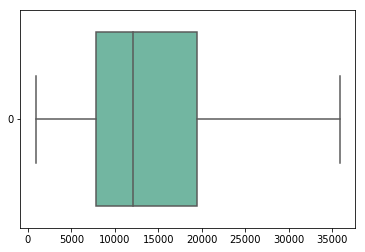

In [26]:
ax = sns.boxplot(data=train['current_loan_amount'], orient="h", palette="Set2")

In [ ]:
train.describe()

#### Outlier treatment: Annual Income

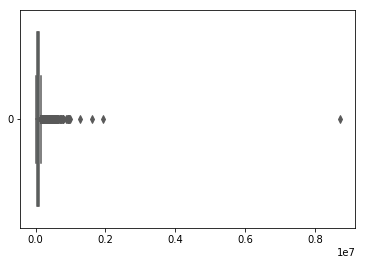

In [27]:
ax = sns.boxplot(data=train['annual_income'], orient="h", palette="Set2")

In [28]:
train[train['annual_income']==8713547.000]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
1574,6dfd2f9c-b796-4cb3-8f71-04d6ae8a8f92,ceee183a-9b02-4b82-ae53-14ccd5f785fd,Charged Off,8006.000,Short Term,725.000,10.000,Home Mortgage,8713547.000,Debt Consolidation,798.740,16.000,nan,11,0,16462,30429,0.000,0.000


In [29]:
train = train[train['annual_income']!=8713547.000]
train.shape

(62235, 19)

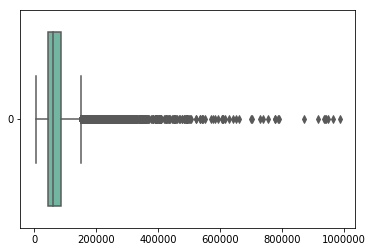

In [33]:
ax = sns.boxplot(data=train['annual_income'], orient="h", palette="Set2")

In [31]:
train[train['annual_income']>1200000]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
3686,d728b670-7248-4c64-b99e-251d9e7b88a2,a0222c05-0157-4791-b2b9-c74d51774d16,Charged Off,34430.000,Long Term,739.000,0.000,Home Mortgage,1623105.000,Debt Consolidation,2637.550,14.700,17.000,15,0,26265,69668,0.000,0.000
11660,cbd2df62-ea45-4ae0-bbeb-1681d5655221,97b34fe1-09e4-4c27-b8cc-ec335ec29891,Charged Off,15928.000,Long Term,733.000,2.000,Home Mortgage,1262125.000,Debt Consolidation,22939.120,19.200,nan,10,0,48726,58565,0.000,0.000
46615,076e5ce5-cc5a-4c3e-8e11-91c31a4fa00e,ecc52a5d-a428-455c-9ae6-332cafac55b2,Fully Paid,28291.000,Short Term,747.000,6.000,Own Home,1919760.000,Debt Consolidation,335.960,11.200,nan,7,0,13889,25768,0.000,0.000


In [32]:
train = train.drop([3686, 11660, 46615])

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


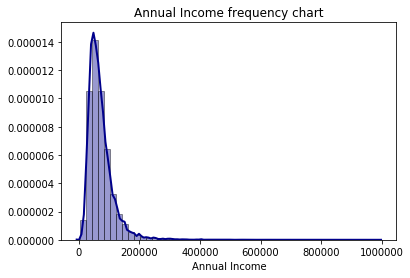

In [34]:
ax = sns.distplot(train['annual_income'].dropna(), hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Annual Income') 
plt.title('Annual Income frequency chart'); 
plt.show()

In [ ]:
train.describe()

#### Outlier Treatment: Years of Credit History

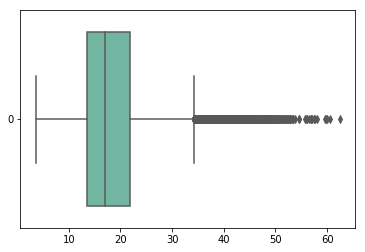

In [35]:
ax = sns.boxplot(data=train['years_of_credit_history'], orient="h", palette="Set2")

In [36]:
train[train['years_of_credit_history']>58]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
1908,cd5ca817-ff39-41e1-8dcd-3a86346c4631,33dd7f5c-92fa-4dcf-b798-6565b8281f0d,Fully Paid,14829.000,Short Term,741.000,7.000,Home Mortgage,86008.000,Business Loan,860.800,59.900,nan,9,1,4558,9596,1.000,0.000
32096,433a4adf-886b-4df7-998a-a0e171fb98bc,7e068df8-61ed-4418-9e6f-9d7610f3238f,Fully Paid,14802.000,Short Term,nan,nan,Home Mortgage,nan,Debt Consolidation,821.020,62.500,24.000,8,0,7007,23593,0.000,0.000
45779,0ca8800a-36f0-48b3-9564-2cce86190862,b6d390e3-8cb6-44b7-981a-ce00be0ca85f,Charged Off,21197.000,Short Term,nan,10.000,Home Mortgage,nan,Debt Consolidation,1574.660,60.500,48.000,11,1,7928,19575,1.000,0.000
49017,133375dc-a8ef-481a-854e-2958fc7ca9f6,a23f7854-accc-48c6-8634-d9277f92c10b,Charged Off,20190.000,Short Term,710.000,10.000,Home Mortgage,46290.000,Home Improvements,690.490,59.700,nan,7,0,2865,7091,0.000,0.000
61832,7e687480-14cb-416e-bc82-faea0ccf2a71,0c401d4d-523a-4eb5-97b0-f5677fd34ade,Fully Paid,34192.000,Long Term,676.000,10.000,Home Mortgage,126509.000,Debt Consolidation,3478.990,59.500,nan,15,0,59003,71259,0.000,0.000


In [37]:
train = train.drop([1908, 32096, 45779, 49017, 61832])

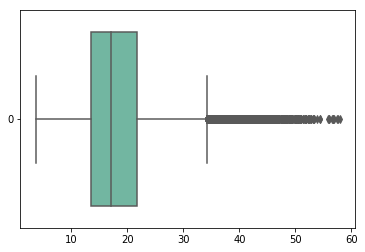

In [38]:
ax = sns.boxplot(data=train['years_of_credit_history'], orient="h", palette="Set2")

In [ ]:
train.describe()

#### Outlier treatment: Number of Open Accounts

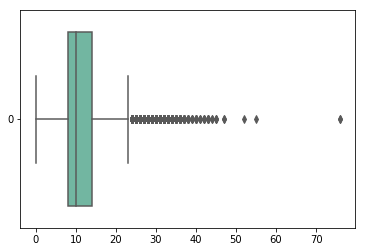

In [39]:
ax = sns.boxplot(data=train['number_of_open_accounts'], orient="h", palette="Set2")

In [40]:
train[train['number_of_open_accounts']>50]

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
26502,7d000d90-1538-4d4d-b7c2-15724be2025e,080f449b-c0b7-4226-8a51-cdcc7e68954f,Fully Paid,6082.000,Short Term,742.000,10.000,Home Mortgage,71973.000,Debt Consolidation,422.840,18.700,nan,52,0,7234,164404,0.000,0.000
26637,4f8a7824-b9bd-4b8c-b2a1-6b7b196d2c0f,67a534d6-7038-4e0b-8d42-8aab6d220701,Fully Paid,28185.000,Long Term,744.000,2.000,Home Mortgage,201320.000,Debt Consolidation,4429.040,15.600,nan,55,0,34159,185646,0.000,0.000
27936,08dab131-9db3-4184-a32a-e12e48fd5d6c,907c2a89-76f8-4089-9a47-d410bb885339,Charged Off,18755.000,Long Term,670.000,7.000,Rent,46912.000,Debt Consolidation,1032.060,27.400,nan,76,0,22111,28131,0.000,0.000
39254,f4e0a453-a5ec-4011-9513-9d203ffe8e3c,3e62a9e2-a61b-472d-8e56-234e30061580,Charged Off,20426.000,Short Term,708.000,5.000,Home Mortgage,122556.000,Debt Consolidation,2195.800,15.700,nan,76,0,40606,121575,0.000,0.000


In [41]:
train = train.drop([26502, 26637, 27936, 39254])

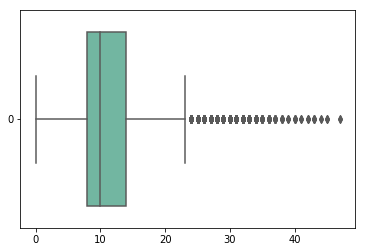

In [42]:
ax = sns.boxplot(data=train['number_of_open_accounts'], orient="h", palette="Set2")

In [43]:
#Capping the outliers
IQR = train['number_of_open_accounts'].quantile(0.75) - train['number_of_open_accounts'].quantile(0.25)
upper_limit = train['number_of_open_accounts'].quantile(0.75) + (IQR * 1.5)
print("Upper Limit:", upper_limit)

Upper Limit: 23.0


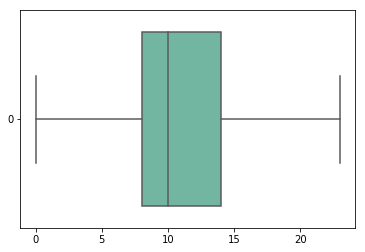

In [44]:
train['number_of_open_accounts'] = [23.0 if ( x>23.0 and x!=np.nan) else x for x in train['number_of_open_accounts']]
ax = sns.boxplot(data=train['number_of_open_accounts'], orient="h", palette="Set2")

In [ ]:
print(train.shape)
train.describe()

Now, all outliers has been handled so let's check the missing values.

In [45]:
train.isnull().sum()

loan_id                             0
customer_id                         0
loan_status                         0
current_loan_amount              5861
term                                0
credit_score                    11237
years_in_current_job             2676
home_ownership                      0
annual_income                   11237
purpose                             0
monthly_debt                        0
years_of_credit_history             0
months_since_last_delinquent    34024
number_of_open_accounts             0
number_of_credit_problems           0
current_credit_balance              0
maximum_open_credit                 0
bankruptcies                      125
tax_liens                           4
dtype: int64

#### Missing Value Treatment: Bankruptcies & Tax Liens

Reference Link for Iterative Imputing:
https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py

In [ ]:
# Since percentage value of Missing values in Bankruptcies and Tax Liens are very low we can delete the rows
train = train.dropna(subset=['bankruptcies', 'tax_liens'])
print(train.shape)
train.isnull().sum()


#### Missing Value Treatment: Months Since Last Delinquent

This feature describes the number of months since the credit is not paid, so NA's actually are the genuine customers so replacing it with 0.

In [ ]:
train["months_since_last_delinquent"].fillna(0, inplace = True)
print(train.shape)
train.isnull().sum()

#### Missing Value Treatment: Current Loan Amount, Credit Score, Years In Current Job, Annual Income

Applying **'Iterative Imputer'** using default estimator **'Bayesian Ridge'** which is **Regularized Linear Regression**.

In [ ]:
train.reset_index(drop=True, inplace=True)
my_imputer = IterativeImputer()
#For this we need only numerical variables so filtering this
train_numerical = train._get_numeric_data()
train_numerical_columns = train_numerical.columns 
print(train_numerical.shape)
train_numerical.isnull().sum()

In [ ]:
train_imputed = my_imputer.fit_transform(train_numerical)
#Imputer will give the array as an object so need to convert it to Dataframe with columns
train_imputed = pd.DataFrame(train_imputed, columns=train_numerical_columns)
train_imputed.isnull().sum()

In [ ]:
train_imputed.describe()

Plotting histogram to see the difference between without na values and after replacing na values with Iterative Imputer. <br>
train_numerical is our Dataframe with NA's, while, train_imputed is our Dataframe without NA's.

#### Histogram: Current Loan Amount

In [ ]:
ax = sns.distplot(train_numerical['current_loan_amount'].dropna(), hist=True, kde=True, 
             bins=int(42740/1000), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Current Loan Amount') 
plt.title('Current Loan Amount before Imputation'); 
plt.show()

In [ ]:
ax = sns.distplot(train_imputed['current_loan_amount'], hist=True, kde=True, 
             bins=int(42740/1000), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Current Loan Amount') 
plt.title('Current Loan Amount after Imputation'); 
plt.show()

In [ ]:
temp = train_imputed[train_imputed['current_loan_amount']<40000]

In [ ]:
ax = sns.distplot(temp['current_loan_amount'], hist=True, kde=True, 
             bins=int(42740/1000), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Current Loan Amount') 
plt.title('Current Loan Amount after Imputation'); 
plt.show()

#### Histogram: Credit Score

In [ ]:
ax = sns.distplot(train_numerical['credit_score'].dropna(), hist=True, kde=True, 
             bins=int(800/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Credit Score') 
plt.title('Credit Score before Imputation'); 
plt.show()

In [ ]:
ax = sns.distplot(train_imputed['credit_score'], hist=True, kde=True, 
             bins=int(800/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Credit Score') 
plt.title('Credit Score after Imputation'); 
plt.show() 

#### Histogram: Annual Income

In [ ]:
ax = sns.distplot(train_numerical['annual_income'].dropna(), hist=True, kde=True, 
             bins=int(215580/10000), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Annual Income') 
plt.title('Annual Income before Imputation'); 
plt.show()

In [ ]:
ax = sns.distplot(train_imputed['annual_income'], hist=True, kde=True, 
             bins=int(215580/10000), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Annual Income') 
plt.title('Annual Income after Imputation'); 
plt.show()

#### Histogram: Years In Current Job

In [ ]:
ax = sns.distplot(train_numerical['years_in_current_job'].dropna(), hist=True, kde=True, 
             bins=int(215580/10000), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Years In Current Job') 
plt.title('Years In Current Job before Imputation'); 
plt.show()

In [ ]:
ax = sns.distplot(train_imputed['years_in_current_job'], hist=True, kde=True, 
             bins=int(215580/10000), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set(xlabel='Years In Current Job') 
plt.title('Years In Current Job after Imputation'); 
plt.show()

Replacing the feature in Train dataframe by above Imputed dataframe.

In [ ]:
train_imputed.shape

In [ ]:
train.shape

In [ ]:
train['years_in_current_job'] = train_imputed['years_in_current_job']
train['current_loan_amount'] = train_imputed['current_loan_amount']
train['credit_score'] = train_imputed['credit_score']
train['annual_income'] = train_imputed['annual_income']

In [ ]:
print(train.shape)
train.isnull().sum()

#### Converting Months since last delinquent into categories

In [ ]:
train['months_since_last_delinquent'] = ['extreme_risk' if x>51 
        else 'high_risk' if x>32 
        else 'moderate_risk' if x>16 
        else 'low_risk' if x>0 else 'no_risk' for x in train['months_since_last_delinquent']]

In [ ]:
train['months_since_last_delinquent'].unique()

**Dropping of Loan ID and Customer ID as we have removed the duplicates and now it's not required further.**

In [ ]:
train.drop(['loan_id', 'customer_id'], axis=1, inplace=True)

In [ ]:
train.shape

### Handling Categorical Variables

We have 5 Categorical Variables in our data which are as below: <br>
1. Term
2. Home Ownership
3. Purpose
4. Months Since Last Delinquent
5. Loan Status

We will apply Label Encoding to Loan Status as this is a dependent variable, while for other we will apply One Hot Encoding.

In [ ]:
# importing one hot encoder from sklearn 
from sklearn.preprocessing import LabelEncoder

In [ ]:
#Applying Label Encoding to Loan Status
le = LabelEncoder()
train['loan_status'] = le.fit_transform(train.loan_status)
print(le.classes_)

In [ ]:
train.loan_status.unique()

In [ ]:
train.term.unique()

In [ ]:
train.home_ownership.unique()

In [ ]:
train['home_ownership'] = ['Mortgage' if 'Mortgage' in x else x for x in train['home_ownership']]

In [ ]:
train.home_ownership.unique()

In [ ]:
train.purpose.unique()

So if you see here there can be n number of purpose to take loan its define and its actually not needed to train the model so dropping this feature.

In [ ]:
train.drop(['purpose'], axis=1, inplace=True)

In [ ]:
train.months_since_last_delinquent.unique()

In [ ]:
cols_to_transform = ['term', 'months_since_last_delinquent', 'home_ownership' ]
train_with_dummies = pd.get_dummies(train, prefix=cols_to_transform )

In [ ]:
train_with_dummies

### EDA

#### Checking the distribution of Dependent Variable

In [ ]:
# This give you the calulation of the target lebels. Which category of the target lebel is how many percentage.
total_len = len(train_with_dummies['loan_status'])
percentage_labels = (train_with_dummies['loan_status'].value_counts()/total_len)*100
percentage_labels

In [ ]:
# Graphical representation of the target label percentage.
sns.set()
sns.countplot(train_with_dummies.loan_status).set_title('Data Distribution')
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100*(height/total_len)),
            fontsize=14, ha='center', va='bottom')
sns.set(font_scale=2)
sns.set(rc={'figure.figsize':(8,8)})
ax.set_xlabel("Labels for Loan Status attribute")
ax.set_ylabel("Numbers of records")
plt.show()

In [ ]:
# Get the correlation of the training dataset
correlation = train_with_dummies[1:].corr()
correlation

In [ ]:
sns.set(font_scale=0.8)
sns.heatmap(train_with_dummies[1:].corr(),annot=True,fmt=".1f")
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

### Feature Selection

In [ ]:
X = train_with_dummies.drop('loan_status',axis=1)
y = train_with_dummies.loan_status

In [ ]:
features_label = X.columns

In [ ]:
#Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0)
classifier.fit(X, y)
importances = classifier.feature_importances_
print(importances)

In [ ]:
indices = np.argsort(importances)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

In [ ]:
plt.title('Feature Importances')
plt.bar(range(X.shape[1]),importances[indices], color="green", align="center")
plt.xticks(range(X.shape[1]),features_label, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### Train and Build Baseline Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection  import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
Random = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, 
                               random_state=None, verbose=0)

Random.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred = Random.predict(X_test)

# Making the Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [ ]:
cm

In [ ]:
#Let's see how our model performed
print(classification_report(y_test, y_pred))

In [ ]:
test_labels=Random.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

In [ ]:
import matplotlib.pyplot as plt
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(cm,classes=[0,1])
sns.set(rc={'figure.figsize':(6,6)})
plt.show()

#### Filtering Features

In [ ]:
X_filter = X[['current_loan_amount', 'credit_score', 'years_in_current_job', 'annual_income', 'monthly_debt', 'years_of_credit_history',
             'number_of_open_accounts', 'number_of_credit_problems', 'current_credit_balance']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_filter, y, test_size = 0.20, random_state = 42)

In [ ]:
Random = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, 
                               random_state=None, verbose=0)

Random.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred = Random.predict(X_test)

# Making the Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [ ]:
cm

In [ ]:
#Let's see how our model performed
print(classification_report(y_test, y_pred))

In [ ]:
test_labels=Random.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

#### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
#rf_random.best_params_
#{'bootstrap': True,
# 'max_depth': None,
# 'max_features': 'auto',
# 'min_samples_leaf': 2,
# 'min_samples_split': 10,
# 'n_estimators': 157}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
Random = RandomForestClassifier(n_estimators=157, criterion='gini', max_depth=None, min_samples_split=10,
                               min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, 
                               random_state=None, verbose=0)

Random.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred = Random.predict(X_test)

# Making the Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [ ]:
cm

In [ ]:
#Let's see how our model performed
print(classification_report(y_test, y_pred))

In [ ]:
test_labels=Random.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

In [ ]:
model = LogisticRegression()

In [ ]:
model.fit(X_train,y_train) 

In [ ]:
from sklearn.linear_model import LogisticRegression
Logistic = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, 
                            random_state=None, solver='liblinear', max_iter=100,
                            multi_class='ovr', verbose=2)
Logistic.fit(X_train, y_train)
